![title](static/wcar.png)

# Victor VSGs in *Trypanosoma brucei*

## set up notebook

In [1]:
#!rm genomes/tb927_6/*

In [2]:
#reload when modified
%load_ext autoreload
%autoreload 2
#activate r magic
%load_ext rpy2.ipython
%matplotlib inline

In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import utilities as UT
import missingno as msno
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import gc
from io import StringIO
from itertools import islice
from Bio import SeqIO

random.seed(1976)
np.random.seed(1976)

In [10]:
import multiprocessing
multiprocessing.cpu_count()

56

# Data Anaylsis

In [11]:
#path = '/cluster/majf_lab/mtinti/Calvin/ESAG3_RNAi/F21FTSEUHT2083_TRYeqlrR/clean/InData/CD_Search/'

def get_fasta_desc(fasta_desc):
    res = {}
    for n in fasta_desc.split(" | "):
        if '=' in n:
            key = n.split('=')[0].strip()
            value = n.split('=')[1].strip()
            res[key]=value
    return res

# from io import StringIO
def read_csv(filename, comment='#', sep='\t', ):
    lines = "".join([line for line in open(filename) 
                     if not line.startswith(comment)])
    return pd.read_csv(StringIO(lines), sep=sep)

df_list = []
for f in ['/homes/mtinti/mtinti_2/DH_Douglas/vsg_victor/InData/CD_Search/927_{}_hitdata.txt'.format(n) for n in range(0,4)]:
    temp = read_csv(f)
    temp['seq_id'] = [n.split(' ')[2][1:] for n in temp['Query']]
    temp['gene_id'] = [get_fasta_desc(n)['gene'] for n in temp['Query']]
    df_list.append(temp)
df_domains=pd.concat(df_list)
df_domains.tail()



,Query,Hit type,PSSM-ID,From,To,E-Value,Bitscore,Accession,Short name,Incomplete,Superfamily,seq_id,gene_id
2016,Q#2196 - >seq_11195 Tb11.1690:pseudogenic_tran...,non-specific,395732,88,403,2.926680e-04,43.1506,pfam00913,Trypan_glycop,-,-,seq_11195,Tb11.1690
2017,Q#2196 - >seq_11195 Tb11.1690:pseudogenic_tran...,superfamily,287612,475,514,8.069620e-03,36.2338,cl11264,Trypan_glycop_C superfamily,C,-,seq_11195,Tb11.1690
2018,Q#2197 - >seq_11196 Tb11.1700:pseudogenic_tran...,non-specific,395732,216,516,9.775360e-07,50.8546,pfam00913,Trypan_glycop,-,-,seq_11196,Tb11.1700
2019,Q#2202 - >seq_11201 Tb11.1800:pseudogenic_tran...,superfamily,302859,1,387,4.186380e-164,478.5540,cl19421,RHSP superfamily,C,-,seq_11201,Tb11.1800
2020,Q#2203 - >seq_11202 Tb11.1810.1-p1 | transcrip...,superfamily,302859,1,222,7.326060e-103,315.2300,cl19421,RHSP superfamily,N,-,seq_11202,Tb11.1810


In [12]:
domain_dict = {}
for temp_id in df_domains.gene_id.unique():
    temp = df_domains[df_domains['gene_id']==temp_id]
    domains = list(temp['Short name'].values) 
    domains = '; '.join(domains)
    domain_dict[temp_id]=domains
domain_dict[list(domain_dict.keys())[0]]

'VSG_B; Trypan_glycop_C'

In [13]:
#create a dictionary of gene to desc
#from the gff file
def make_desc(_GFF):
    gff =pd.read_csv( _GFF, sep='\t', header=None, comment='#')
    #print(gff)
    gff = gff[gff.iloc[:,2].str.contains('gene')]
    #print( gff[gff[gff.columns[-1]].str.contains('Tb427_020006200')] )
    #print(gff)
    desc = {}
    chr_dict = {}
    start_dict = {}
    sense_dict = {}
    for index,n in enumerate(gff.iloc[:,-1]):
        n=n.replace('%2C',' ')
        item_list = n.split(';')
        #print (item_list)
        temp_dict = {}
        for m in item_list:
            #print(m)
            temp_dict[m.split('=')[0].strip()]=m.split('=')[1].strip()
        #print(temp_dict['ID'])
        #print(temp_dict['description'])
        desc[temp_dict['ID']]=temp_dict.get('description','none')
        chr_dict[temp_dict['ID']]=gff.iloc[index][0]
        start_dict[temp_dict['ID']]=gff.iloc[index][3]
        sense_dict[temp_dict['ID']]=gff.iloc[index][6]
        
    return desc,chr_dict,start_dict,sense_dict

desc_dict_gff, _, _,_ = make_desc('/homes/mtinti/mtinti_2/DH_Douglas/vsg_victor/InData/TriTrypDB-55_TbruceiTREU927.gff')

#(list(desc_dict.keys())[0],
# desc_dict[list(desc_dict.keys())[0]],
# chr_dict[list(desc_dict.keys())[0]],
# start_dict[list(desc_dict.keys())[0]],
#sense_dict[list(desc_dict.keys())[0]],
#)
#desc_dict_gff

In [14]:
#!cp genomes/tb427/tb427.gff .

In [15]:
#create a dictionary of gene to desc
#from the gff file
def make_desc(_GFF):
    gff =pd.read_csv( _GFF, sep='\t', header=None, comment='#')
    
    gff = gff[gff.iloc[:,2]=='exon']
    
    #print( gff[gff[gff.columns[-1]].str.contains('Tb427_020006200')] )
    desc = {}
    chr_dict = {}
    start_dict = {}
    sense_dict = {}
    for index,n in enumerate(gff.iloc[:,-1]):
        #print(n)
        n=n.replace('%2C',' ')
        item_list = n.split(';')
        item_list = [n for n in item_list if len(n)>0]
        temp_dict = {}
        
        for m in item_list:
            
            temp_dict[m.strip().split(' ')[0].strip().replace('\"','')
                     ]=m.strip().split(' ')[1].strip().replace('\"','')
        #print(temp_dict)
        #print(temp_dict['description'])
        desc[temp_dict['gene_id']]=temp_dict.get('description',temp_dict['gene_id'])
        chr_dict[temp_dict['gene_id']]=gff.iloc[index][0]
        start_dict[temp_dict['gene_id']]=gff.iloc[index][3]
        sense_dict[temp_dict['gene_id']]=gff.iloc[index][6]
        
    return desc,chr_dict,start_dict,sense_dict

desc_dict, chr_dict, start_dict,sense_dict = make_desc('genomes/tb927_56/tb927_56.gtf')
(list(desc_dict.keys())[0],
 desc_dict[list(desc_dict.keys())[0]],
 chr_dict[list(desc_dict.keys())[0]],
 start_dict[list(desc_dict.keys())[0]],
sense_dict[list(desc_dict.keys())[0]],
)

('gene_Tb427VSG-3039', 'gene_Tb427VSG-3039', 'Tb427VSG-3039', 1, '+')

In [16]:
desc_dict.update(desc_dict_gff)

In [17]:
desc_dict['gene-Tb427.BES40.1']

'gene-Tb427.BES40.1'

In [18]:
desc_dict['gene_Tb427VSG-3039']

'gene_Tb427VSG-3039'

In [19]:
replace_list = eval(open('vars_def_vsg_10_2').read())
list_df = [n['experiment'] for n in replace_list]
list_df

['A25', 'A5', 'A9', 'B25', 'B5', 'B9', 'C25', 'C5', 'C9']

In [20]:
#read all the rna-seq reads counts for each sampe
#exp = '{life_stage}{replica}'
#list_df = [exp.format(
#    life_stage=life_stage,
#    replica=replica) 
# for life_stage in ['C','T']
# for replica in ['1','2','3']]

#aggregate counts in one dataframe
list_df = [n+'/res5_927/'+n+'/counts.txt' for n in list_df]
list_df =[pd.read_csv(n,index_col=[0],comment='#',sep='\t') for n in list_df]
df = list_df[0].copy()
for temp_df in list_df[1:]:
    df = df.join(temp_df.iloc[:,-1])
df.head()
#temp_df = pd.read_csv('BSF/tb927_3_ks_counts_final.txt',index_col=[0],comment='#',sep='\t')

,Chr,Start,End,Strand,Length,/tmp/1152431.1.all.q/A25/A25sorted.bam,/tmp/1152432.1.all.q/A5/A5sorted.bam,/tmp/1152433.1.all.q/A9/A9sorted.bam,/tmp/1152434.1.all.q/B25/B25sorted.bam,/tmp/1152435.1.all.q/B5/B5sorted.bam,/tmp/1152436.1.all.q/B9/B9sorted.bam,/tmp/1152437.1.all.q/C25/C25sorted.bam,/tmp/1152438.1.all.q/C5/C5sorted.bam,/tmp/1152439.1.all.q/C9/C9sorted.bam
Geneid,,,,,,,,,,,,,,
gene_Tb427VSG-2,Tb427VSG-2,1,1199,+,1199,7179,73178,10795,7689,70601,11232,6762,70928,11530
gene_Tb427VSG-3039,Tb427VSG-3039,1,1199,+,1199,4872,41264,33334,5920,35853,34598,5497,36398,33364
gene_Tb427VSG-23,Tb427VSG-23,1,1199,+,1199,413064,399745,432124,463716,326479,496247,464987,315952,490114
gene_Tb427VSG-649,Tb427VSG-649,1,1199,+,1199,445,2808,2264,689,2481,2571,473,2369,2581
gene_Tb427VSG-22,Tb427VSG-22,1,1199,+,1199,7060,9134,8664,6538,8278,9228,7010,8255,8864


In [21]:
data_col = df.columns[5:]
data_col

Index(['/tmp/1152431.1.all.q/A25/A25sorted.bam',
       '/tmp/1152432.1.all.q/A5/A5sorted.bam',
       '/tmp/1152433.1.all.q/A9/A9sorted.bam',
       '/tmp/1152434.1.all.q/B25/B25sorted.bam',
       '/tmp/1152435.1.all.q/B5/B5sorted.bam',
       '/tmp/1152436.1.all.q/B9/B9sorted.bam',
       '/tmp/1152437.1.all.q/C25/C25sorted.bam',
       '/tmp/1152438.1.all.q/C5/C5sorted.bam',
       '/tmp/1152439.1.all.q/C9/C9sorted.bam'],
      dtype='object')

In [22]:
#rename columns for convenience
indata = df[data_col]
indata.columns = [n.split('/')[3] for  n in indata.columns]
indata.head()

,A25,A5,A9,B25,B5,B9,C25,C5,C9
Geneid,,,,,,,,,
gene_Tb427VSG-2,7179,73178,10795,7689,70601,11232,6762,70928,11530
gene_Tb427VSG-3039,4872,41264,33334,5920,35853,34598,5497,36398,33364
gene_Tb427VSG-23,413064,399745,432124,463716,326479,496247,464987,315952,490114
gene_Tb427VSG-649,445,2808,2264,689,2481,2571,473,2369,2581
gene_Tb427VSG-22,7060,9134,8664,6538,8278,9228,7010,8255,8864


In [23]:
data_col = df.columns[5:]
data_col

Index(['/tmp/1152431.1.all.q/A25/A25sorted.bam',
       '/tmp/1152432.1.all.q/A5/A5sorted.bam',
       '/tmp/1152433.1.all.q/A9/A9sorted.bam',
       '/tmp/1152434.1.all.q/B25/B25sorted.bam',
       '/tmp/1152435.1.all.q/B5/B5sorted.bam',
       '/tmp/1152436.1.all.q/B9/B9sorted.bam',
       '/tmp/1152437.1.all.q/C25/C25sorted.bam',
       '/tmp/1152438.1.all.q/C5/C5sorted.bam',
       '/tmp/1152439.1.all.q/C9/C9sorted.bam'],
      dtype='object')

In [24]:
print(indata.shape)
indata=indata.dropna()
print(indata.shape)
#indata.loc['KS17gene_1749a']
#indata['desc']=[desc_dict.get(n,'none') for n in indata.index.values]
#indata.to_csv('indata.csv')
#indata.head()
#indata.loc['mainVSG-427-2']

#indata = indata.replace(1,np.nan).dropna(axis=1, how='all')
#print(indata.shape)
#indata.describe()

(43, 9)
(43, 9)


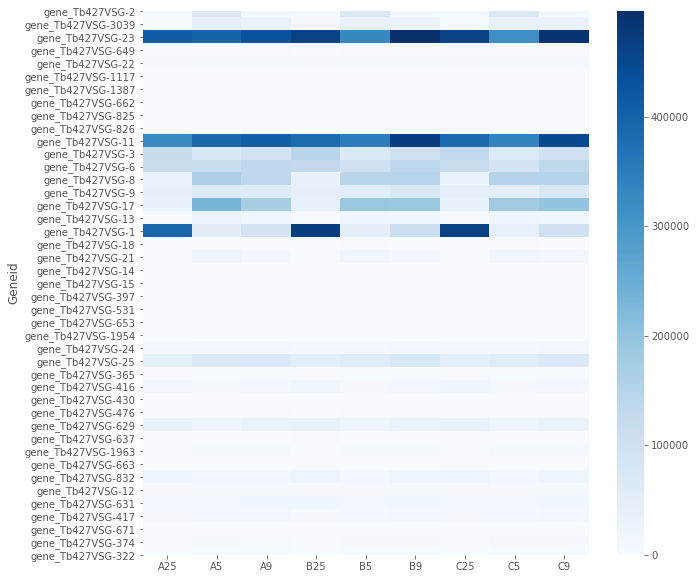

In [25]:
fig,ax=plt.subplots(figsize=(10,10))
sns.heatmap(indata,ax=ax,cmap='Blues')
plt.savefig('heatmap.png')

In [26]:
indata.to_csv('vsg_count.csv')

## QC - Missing Data Viz

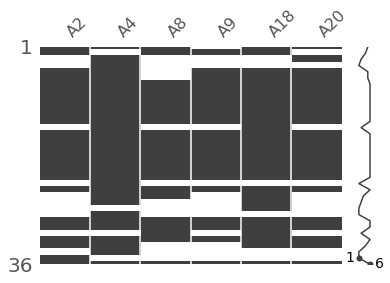

In [19]:
msno.matrix(indata.replace(0,np.nan).dropna(how='all'),figsize=(6, 4))

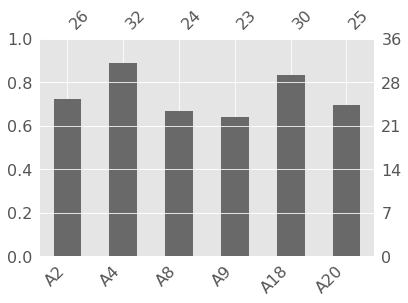

In [20]:
msno.bar(indata.replace(0,np.nan).dropna(how='all'),figsize=(6, 4))

## QC - Corr analysis

In [21]:
!mkdir -p Figures_927

(5.5, 0.5)


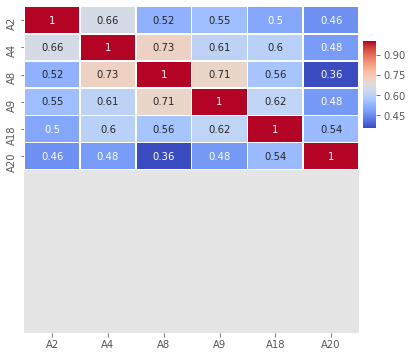

In [22]:
fig,ax=plt.subplots(figsize=(6,6))
cbar_ax = fig.add_axes([.91, .6, .03, .2])
sns.heatmap(np.log2(indata).corr(),
            #vmin=-1,
            cmap='coolwarm',
            annot=True,linewidths=.5,ax=ax, cbar_ax = cbar_ax, cbar=True)
print(ax.get_ylim())
ax.set_ylim(12,0)
#plt.savefig('Figures_927/Figure_2.png')
plt.show()

## QC - MSD

In [23]:
#plt.style.use('ggplot')
#palette = ['r']*5+['b']*5+['y']*5
#fig,ax = plt.subplots(figsize=(8,8), ncols=1, nrows=1)
#UT.make_mds(np.log2(indata),palette,ax,color_dictionary={'r':'1','b':'2','y':'3',
#                                                        })
#plt.savefig('Figures_927/Figure_3.png')
#plt.show()

## Compute Length and GC content
this information is used to check for length and GC bias

In [30]:
#!mkdir -p InData

In [31]:
#!cp genomes/tb927_56/tb927_56.gtf .
#!cp genomes/tb927_55/tb927_55.fa .
#!cp genomes/tb927_55/tb927_55.fa.fai .

#!gtf2bed < tb927_55.gtf > tb927_55.bed
#!bedtools nuc -fi tb927_55.fa -bed tb927_55.bed >InData/GC_content_927.txt

In [32]:
#!bowtie2-build genomes/tb927_5/tb927_5.fa genomes/tb927_5/tb927_5

In [33]:
def get_gene_ids(n):
    res = {}
    temp = n.split(';')
    temp =[n.strip() for n in temp if len(n)>2]
    temp = temp[:2]
    #print(temp)
    for f in temp:
        key = f.split(' ')[0]
        value = f.split(' ')[1]
        key=key.replace('\"','').replace('\'','').strip()
        value=value.replace('\"','').replace('\'','').strip()
        res[key]=value
    return res['gene_id']

In [34]:
gc_content = pd.read_csv('/homes/mtinti/mtinti_2/DH_Douglas/vsg_victor/InData/GC_content_927.txt',sep='\t')
gc_content = gc_content[gc_content['8_usercol']=='CDS']
#print(gc_content)
gc_content['gene_id'] = [get_gene_ids(n) for n in gc_content['10_usercol']]
gc_content = gc_content.drop_duplicates('gene_id')
gc_content.set_index('gene_id',inplace=True)
gc_content=gc_content[['19_seq_len','12_pct_gc']]
gc_content.columns = ['length', 'gccontent']
gc_content.loc['gene-Tb427.BES40.14']

length       1893.000000
gccontent       0.436873
Name: gene-Tb427.BES40.14, dtype: float64

In [35]:
gc_content.head()

,length,gccontent
gene_id,,
Tb07.11L3.90,1131,0.510168
Tb07.11L3.100,3795,0.500132
Tb05.5K5.10,72,0.402778
Tb05.5K5.20,1278,0.461659
Tb05.5K5.30,1911,0.480900


In [36]:
metadata=pd.DataFrame()
metadata['samples']=indata.columns
metadata['treatment']=indata.columns
metadata['batch']=1
metadata.reset_index().to_csv('metadata.csv')

In [37]:
print(indata.shape)
indata=indata.join(gc_content,how='inner')
gc_content = gc_content[['length', 'gccontent']]
indata.drop(['length', 'gccontent'],axis=1,inplace=True) 
indata.shape

(42, 6)


(42, 6)

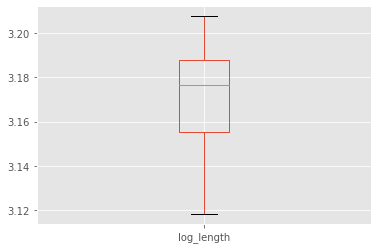

In [39]:
test = indata.join(gc_content)
test['log_length']=np.log10(test['length'])
test['log_length'].plot(kind='box')
#test['log_A3-4']=np.log10(test['A3-4'])
#test.plot(x='log_A3-4',y='log_length', kind='scatter')

### edgeR to filter low counts

In [40]:
#%%R -i indata
#options(warn=-1)
#library("limma") 
#library("edgeR")
#head(indata)

In [41]:
#%%R
#group <- factor(c(
#    'A20','A12','A8','A4','A2','A20','A12','A8','A4','A2','A20','A12','A8','A4','A2'
#))

#y <- DGEList(counts=indata,group=group)
#keep <- filterByExpr(y,min.count = 10, min.total.count = 80)
#y <- y[keep,,keep.lib.sizes=FALSE]
#counts = y$counts
#genes = row.names(y)

In [42]:
#%R -o counts,genes
#indata = pd.DataFrame(counts,index=genes,columns=indata.columns)
indata.shape

(42, 6)

In [43]:
indata=indata.join(gc_content,how='inner')
indata.shape

(42, 8)

### GC / length content

In [44]:
gc_content = indata[['length', 'gccontent']]
indata.drop(['length', 'gccontent'],axis=1,inplace=True)
print(indata.shape,gc_content.shape)
indata.head()

(42, 6) (42, 2)


,A2,A4,A8,A9,A18,A20
gene_Tb427VSG-3039,1,1,3,0,1,19
gene_Tb427VSG-23,0,0,0,0,0,0
gene_Tb427VSG-649,3,0,2,1,1,0
gene_Tb427VSG-22,0,2,0,0,0,1
gene_Tb427VSG-1117,0,1,0,0,0,0


### size factors

In [45]:
#compute for all proteome in FiguresPaper-927-unique_10.ipynb

sizeFactors=np.array([20324734, 17186145, 17833737, 16893075, 17314881, 19590809])
sizeFactors

array([20324734, 17186145, 17833737, 16893075, 17314881, 19590809])

In [46]:
#np.log2(gc_content['length']/1000).plot(kind='hist')

### Bias Correction

In [47]:
%%R -i gc_content,indata,sizeFactors
library(cqn)
library(scales)

R[write to console]: Loading required package: mclust

R[write to console]: Package 'mclust' version 5.4.6
Type 'citation("mclust")' for citing this R package in publications.

R[write to console]: Loading required package: nor1mix

R[write to console]: Loading required package: preprocessCore

R[write to console]: Loading required package: splines

R[write to console]: Loading required package: quantreg

R[write to console]: Loading required package: SparseM

R[write to console]: 
Attaching package: ‘SparseM’


R[write to console]: The following object is masked from ‘package:base’:

    backsolve




In [45]:
%%R
stopifnot(all(rownames(indata) == rownames(gc_content)))
cqn.subset <- cqn(indata, lengths = gc_content$length,
                  x = gc_content$gccontent, sizeFactors = sizeFactors,
                  verbose = TRUE)

RQ fit ...............
SQN .


In [46]:
#%R cqn.subset

### Viz Bias

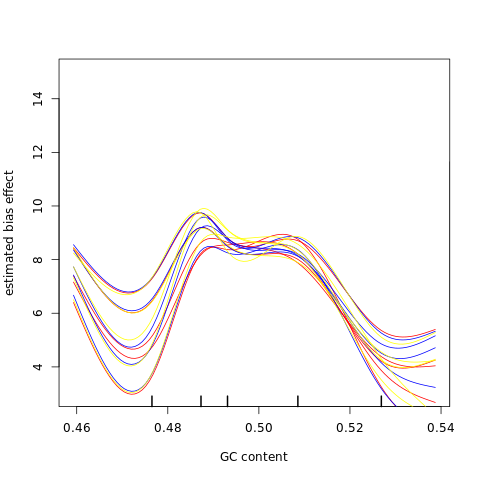

In [47]:
%%R
cqnplot <- function(x, n = 1, col = "grey60", ylab="estimated bias effect", 
                    xlab = "", type = "l", lty = 1, ...) {
    if(class(x) != "cqn")
        stop("'x' needs to be of class 'cqn'")
    if(n == 1) {
        func <- x$func1
        grid <- x$grid1
        knots <- x$knots1
    }
    if(n == 2) {
        if(is.null(x$func2))
            stop("argument 'x' does not appear to have two smooth functions (component 'func2' is NULL)")
        func <- x$func2
        grid <- x$grid2
        knots <- x$knots2
    }
    
    
    #par(mar=c(5.1, 4.1, 4.1, 8.1), xpd=TRUE)
    matplot(replicate(ncol(func), grid), func, ylab = ylab, xlab = xlab, type = type,
            col = col, lty = lty, ...)
    
    legend("bottomleft", legend = colnames(x$counts), inset=c(1,0),
           title="Samples", lty = lty, col = col)
    rug(knots, lwd = 2)
    invisible(x)
    
}


library(repr)
#options(repr.plot.width = 10, repr.plot.height = 0.75)
# Change plot size to 4 x 3
#options(repr.plot.width=4, repr.plot.height=3)


colors <- c(
    'red','red','red','red','red',
    'blue','blue','blue','blue','blue',
'yellow','yellow','yellow','yellow','yellow'
    
)
lty =c(1,1,1,1,1,
       1,1,1,1,1,
       1,1,1,1,1
      )

#png("Figures/Figure_12.png")
#par(mfrow=c(1,2))
cqnplot(cqn.subset, col=colors,
        n = 1, xlab = "GC content", lty = lty,
        ylim = c(3, 15), 
        
       )
#dev.off()

#ggsave('plot.png', width=8.27, height= 11.69) #A4 size in inches
#dev.off()

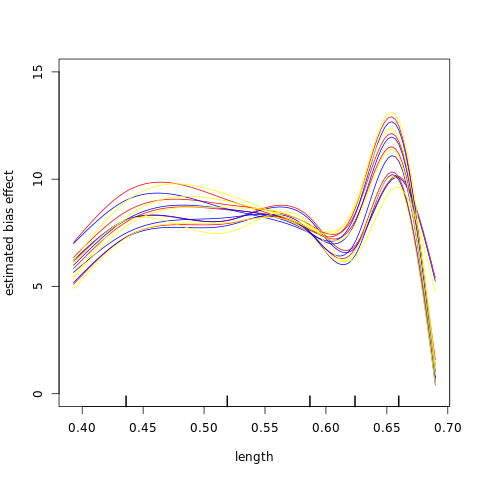

In [48]:
%%R
library(repr)
#options(repr.plot.width = 12, repr.plot.height = 0.75)
# Change plot size to 4 x 3
#options(repr.plot.width=8, repr.plot.height=3)


colors <- c(
    'red','red','red','red','red',
    'blue','blue','blue','blue','blue',
'yellow','yellow','yellow','yellow','yellow'
    
)
lty =c(1,1,1,1,1,
       1,1,1,1,1,
       1,1,1,1,1
      )

#par(mfrow=c(1,2))
#png("Figures/Figure_13.png")
cqnplot(cqn.subset, col=colors,
        n = 2, xlab = "length", lty = lty,
        ylim = c(0,15), 
    
       )
#dev.off()

### Bias Correction

In [49]:
%%R
RPKM.cqn <- cqn.subset$y + cqn.subset$offset
out_table <- RPKM.cqn
head(out_table)

                      A3.20    A3.12      A3.8      A3.4     A3.0    A2.20
gene_Tb427VSG-3039 9.244940 9.658041 10.640695 10.161291 9.978287 9.499739
gene_Tb427VSG-23   9.978287 8.573979  8.759146  8.573979 8.945267 9.040363
gene_Tb427VSG-649  7.826352 8.480115  8.384453  8.184287 7.262255 7.962261
gene_Tb427VSG-22   9.499739 8.851761  8.384453  8.573979 8.573979 8.759146
gene_Tb427VSG-1117 3.784730 3.097556  1.779699  1.018755 1.586508 3.097556
gene_Tb427VSG-1387 8.945267 7.962261  8.384453  7.656935 9.244940 9.137825
                       A2.12      A2.8       A2.4     A2.0     A1.20     A1.12
gene_Tb427VSG-3039 10.370039 11.013356 10.1612910 9.978287 10.161291 11.013356
gene_Tb427VSG-23    9.137825  8.759146  7.9622615 8.945267  9.820702  9.137825
gene_Tb427VSG-649   9.137825  8.759146  8.1842872 7.262255  7.826352  8.480115
gene_Tb427VSG-22    9.137825  8.759146  9.1378247 8.945267  9.366995  8.480115
gene_Tb427VSG-1117  3.097556  4.426477  0.4878581 2.000212  3.097556  3.784730
g

In [50]:
#out_table

In [51]:
%R -o out_table
out_table = pd.DataFrame(out_table,index=indata.index.values,columns=indata.columns)
out_table.head()

,A3-20,A3-12,A3-8,A3-4,A3-0,A2-20,A2-12,A2-8,A2-4,A2-0,A1-20,A1-12,A1-8,A1-4,A1-0
gene_Tb427VSG-3039,9.244940,9.658041,10.640695,10.161291,9.978287,9.499739,10.370039,11.013356,10.161291,9.978287,10.161291,11.013356,11.013356,10.370039,9.978287
gene_Tb427VSG-23,9.978287,8.573979,8.759146,8.573979,8.945267,9.040363,9.137825,8.759146,7.962261,8.945267,9.820702,9.137825,9.244940,8.945267,7.826352
gene_Tb427VSG-649,7.826352,8.480115,8.384453,8.184287,7.262255,7.962261,9.137825,8.759146,8.184287,7.262255,7.826352,8.480115,8.666767,8.759146,6.670245
gene_Tb427VSG-22,9.499739,8.851761,8.384453,8.573979,8.573979,8.759146,9.137825,8.759146,9.137825,8.945267,9.366995,8.480115,8.666767,9.244940,8.851761
gene_Tb427VSG-1117,3.784730,3.097556,1.779699,1.018755,1.586508,3.097556,3.097556,4.426477,0.487858,2.000212,3.097556,3.784730,3.097556,0.652907,3.097556


### Visualise Normalized Counts

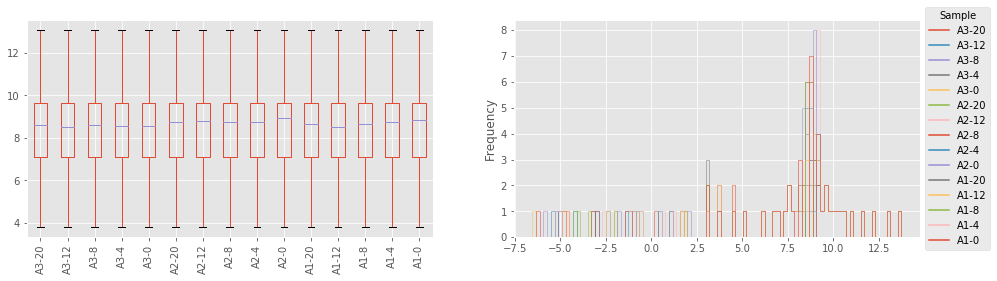

(42, 15)


In [52]:
fig,axes=plt.subplots(figsize=(16,4),ncols=2)
ax = axes[0]
out_table.plot(kind='box',ax=ax,rot=90,showfliers=False)

ax = axes[1]
out_table.replace(-np.inf,-1.5).plot(kind='hist',
                                            histtype='step',
                                            bins=100,ax=ax)
UT.hist_legend(ax,'Sample')
#ax.set_xticklabels(out_df.columns, rotation=90, )
plt.show()
print(out_table.shape)

In [53]:
#gene_Tb427VSG-825     -5.264267
#gene_Tb427VSG-826     -4.359441
#gene_Tb427VSG-662     -2.420824
#gene_Tb427VSG-1117    -0.469746
to_drop = ['gene_Tb427VSG-825', 
           'gene_Tb427VSG-826',
           'gene_Tb427VSG-662', 
           'gene_Tb427VSG-1117']

In [54]:
indata.index.values

array(['gene_Tb427VSG-3039', 'gene_Tb427VSG-23', 'gene_Tb427VSG-649',
       'gene_Tb427VSG-22', 'gene_Tb427VSG-1117', 'gene_Tb427VSG-1387',
       'gene_Tb427VSG-662', 'gene_Tb427VSG-825', 'gene_Tb427VSG-826',
       'gene_Tb427VSG-11', 'gene_Tb427VSG-3', 'gene_Tb427VSG-6',
       'gene_Tb427VSG-8', 'gene_Tb427VSG-9', 'gene_Tb427VSG-17',
       'gene_Tb427VSG-13', 'gene_Tb427VSG-1', 'gene_Tb427VSG-18',
       'gene_Tb427VSG-21', 'gene_Tb427VSG-14', 'gene_Tb427VSG-15',
       'gene_Tb427VSG-397', 'gene_Tb427VSG-531', 'gene_Tb427VSG-653',
       'gene_Tb427VSG-1954', 'gene_Tb427VSG-24', 'gene_Tb427VSG-25',
       'gene_Tb427VSG-365', 'gene_Tb427VSG-416', 'gene_Tb427VSG-430',
       'gene_Tb427VSG-476', 'gene_Tb427VSG-629', 'gene_Tb427VSG-637',
       'gene_Tb427VSG-1963', 'gene_Tb427VSG-663', 'gene_Tb427VSG-832',
       'gene_Tb427VSG-12', 'gene_Tb427VSG-631', 'gene_Tb427VSG-417',
       'gene_Tb427VSG-671', 'gene_Tb427VSG-374', 'gene_Tb427VSG-322'],
      dtype=object)

In [131]:
#temp = out_table.drop(to_drop)
#temp.head()

In [52]:
indata


,A2,A4,A8,A9,A18,A20
gene_Tb427VSG-3039,1,1,3,0,1,19
gene_Tb427VSG-23,0,0,0,0,0,0
gene_Tb427VSG-649,3,0,2,1,1,0
gene_Tb427VSG-22,0,2,0,0,0,1
gene_Tb427VSG-1117,0,1,0,0,0,0
gene_Tb427VSG-1387,1,7,0,3,5,2
gene_Tb427VSG-662,2,14,0,5,3,3
gene_Tb427VSG-825,0,0,0,0,0,0
gene_Tb427VSG-826,0,0,0,0,0,0
gene_Tb427VSG-11,18039,5041276,666,489,676,669


# Compute FPKM

In [54]:
temp = indata.copy()#drop(to_drop)
temp = temp.join(gc_content,how='inner')
temp['length_aa']=round(temp['length']/3)
temp['length_kb']=temp['length']/1000
size_factors = np.array([20324734, 17186145, 17833737, 16893075, 17314881, 19590809])
#       25719475, 25399200, 26374663, 25805849, 26172070, 27200277,
#       26664592, 26211320, 24848832])
size_factors=size_factors/1000000
temp.iloc[:,0:6] = temp.iloc[:,0:6].divide(size_factors, axis=1).divide(temp['length_kb'],axis=0).round(1)
temp.head()
#RPKM = .divide( ( temp['length_kb'] * size_factors/1000000 ),axis=1)
#RPKM

,A2,A4,A8,A9,A18,A20,length,gccontent,length_aa,length_kb
gene_Tb427VSG-3039,0.0,0.0,0.1,0.0,0.0,0.7,1346,0.505201,449.0,1.346
gene_Tb427VSG-23,0.0,0.0,0.0,0.0,0.0,0.0,1541,0.514601,514.0,1.541
gene_Tb427VSG-649,0.1,0.0,0.1,0.0,0.0,0.0,1361,0.511389,454.0,1.361
gene_Tb427VSG-22,0.0,0.1,0.0,0.0,0.0,0.0,1367,0.493050,456.0,1.367
gene_Tb427VSG-1117,0.0,0.0,0.0,0.0,0.0,0.0,1529,0.531720,510.0,1.529


In [55]:
temp.head()

,A2,A4,A8,A9,A18,A20,length,gccontent,length_aa,length_kb
gene_Tb427VSG-3039,0.0,0.0,0.1,0.0,0.0,0.7,1346,0.505201,449.0,1.346
gene_Tb427VSG-23,0.0,0.0,0.0,0.0,0.0,0.0,1541,0.514601,514.0,1.541
gene_Tb427VSG-649,0.1,0.0,0.1,0.0,0.0,0.0,1361,0.511389,454.0,1.361
gene_Tb427VSG-22,0.0,0.1,0.0,0.0,0.0,0.0,1367,0.493050,456.0,1.367
gene_Tb427VSG-1117,0.0,0.0,0.0,0.0,0.0,0.0,1529,0.531720,510.0,1.529


In [56]:
dict_cat = {
'gene_Tb427VSG-11':'BES',
'gene_Tb427VSG-3':'BES',
'gene_Tb427VSG-6':'BES',
'gene_Tb427VSG-8':'BES',
'gene_Tb427VSG-9':'BES',
'gene_Tb427VSG-17':'BES',
'gene_Tb427VSG-13':'BES',
'gene_Tb427VSG-18':'BES',
'gene_Tb427VSG-21':'BES',
'gene_Tb427VSG-14':'BES',
'gene_Tb427VSG-15':'BES',
 
'gene_Tb427VSG-397':'MES',
'gene_Tb427VSG-653':'MES',
'gene_Tb427VSG-531':'MES',
'gene_Tb427VSG-1954':'MES',
'gene_Tb427VSG-631':'MES',
 
'gene_Tb427VSG-1':'MC',
'gene_Tb427VSG-25':'MC',
'gene_Tb427VSG-365':'MC',
'gene_Tb427VSG-416':'MC',
'gene_Tb427VSG-430':'MC',
'gene_Tb427VSG-476':'MC',
'gene_Tb427VSG-629':'MC',
'gene_Tb427VSG-637':'MC',
'gene_Tb427VSG-1963':'MC',
'gene_Tb427VSG-663':'MC',
'gene_Tb427VSG-417':'MC',
'gene_Tb427VSG-671':'MC',
'gene_Tb427VSG-374':'MC',
'gene_Tb427VSG-24':'MC',
'gene_Tb427VSG-832':'MC',
'gene_Tb427VSG-3039':'MC',
'gene_Tb427VSG-23':'MC',
'gene_Tb427VSG-649':'MC',
'gene_Tb427VSG-22':'MC',
'gene_Tb427VSG-1387':'MC',
'gene_Tb427VSG-12':'MC',
'gene_Tb427VSG-322':'MC',
    
'gene_Tb427VSG-12':'ND',
'gene_Tb427VSG-322':'ND',
}

In [57]:
temp['category']=[dict_cat.get(n,'none') for n in temp.index.values]

In [72]:
temp

,A2,A4,A8,A9,A18,A20,length,gccontent,length_aa,length_kb,category
gene_Tb427VSG-3039,0.0,0.0,0.1,0.0,0.0,0.7,1346,0.505201,449.0,1.346,MC
gene_Tb427VSG-23,0.0,0.0,0.0,0.0,0.0,0.0,1541,0.514601,514.0,1.541,MC
gene_Tb427VSG-649,0.1,0.0,0.1,0.0,0.0,0.0,1361,0.511389,454.0,1.361,MC
gene_Tb427VSG-22,0.0,0.1,0.0,0.0,0.0,0.0,1367,0.493050,456.0,1.367,MC
gene_Tb427VSG-1117,0.0,0.0,0.0,0.0,0.0,0.0,1529,0.531720,510.0,1.529,none
gene_Tb427VSG-1387,0.0,0.3,0.0,0.1,0.2,0.1,1451,0.469332,484.0,1.451,MC
gene_Tb427VSG-662,0.1,0.6,0.0,0.2,0.1,0.1,1379,0.482959,460.0,1.379,none
gene_Tb427VSG-825,0.0,0.0,0.0,0.0,0.0,0.0,1559,0.497114,520.0,1.559,none
gene_Tb427VSG-826,0.0,0.0,0.0,0.0,0.0,0.0,1403,0.503207,468.0,1.403,none
gene_Tb427VSG-11,570.4,188517.8,24.0,18.6,25.1,21.9,1556,0.491003,519.0,1.556,BES


In [70]:
#sns.heatmap??

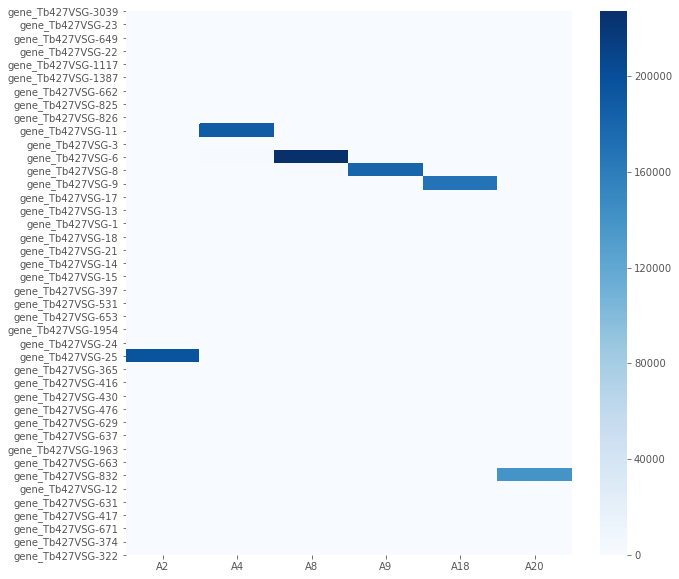

In [79]:
fig,ax=plt.subplots(figsize=(10,10))
sns.heatmap(temp.iloc[:,0:6],ax=ax,cmap='Blues')
plt.savefig('heatmap.png')

In [103]:
#data=temp.groupby('category').mean().iloc[:,0:15].T.drop('none',axis=1)
#data.head()
#data.plot(kind='box')
#data.head()

In [77]:
#data = temp.groupby('category').mean().iloc[:,0:15].T.drop('none',axis=1)
#import seaborn.apionly as sns 
#tips = sns.load_dataset("tips")
#sns.boxplot("day", "tip", data=data, boxprops={'facecolor':'None'})
#sns.swarmplot("day", "tip", data=tips, zorder=.5)

In [87]:
#temp.head()

In [104]:
#temp['y1']=temp['A3-8']/temp['A3-4']
#temp['y2']=temp['A2-8']/temp['A2-4']
#temp['y3']=temp['A1-8']/temp['A1-4']
#temp['std']=temp[['y1','y2','y3']].std(axis=1)
#temp['mean']=temp[['y1','y2','y3']].mean(axis=1)

In [73]:
temp.to_csv('vsg_only.csv')

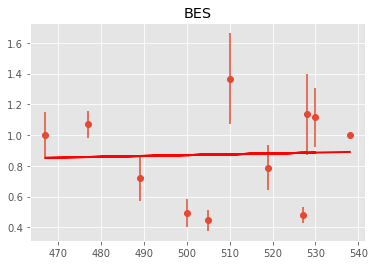

In [106]:

to_plot = temp[temp['category']=='BES']

#temp.plot(y='y1',x='length_aa',kind='scatter')
fig,ax = plt.subplots()
ax.errorbar(to_plot['length_aa'],to_plot['mean'], yerr=to_plot['std'],fmt='o')

from sklearn.linear_model import LinearRegression
regr = LinearRegression(fit_intercept=True)
X=np.array(to_plot['length_aa']).reshape(-1, 1)
regr.fit(X, to_plot['mean'])

plt.plot(to_plot['length_aa'], regr.predict(X), 
         color='red', linewidth=2)
plt.title('BES')
plt.savefig('bes.png')

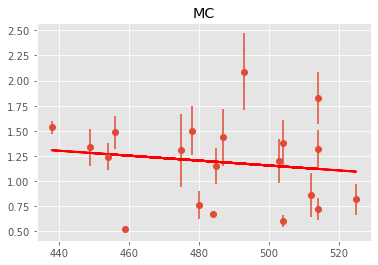

In [107]:
to_plot = temp[temp['category']=='MC']

#temp.plot(y='y1',x='length_aa',kind='scatter')
fig,ax = plt.subplots()
ax.errorbar(to_plot['length_aa'],to_plot['mean'], yerr=to_plot['std'],fmt='o')

from sklearn.linear_model import LinearRegression
regr = LinearRegression(fit_intercept=True)
X=np.array(to_plot['length_aa']).reshape(-1, 1)
regr.fit(X, to_plot['mean'])

plt.plot(to_plot['length_aa'], regr.predict(X), 
         color='red', linewidth=2)
plt.title('MC')
plt.savefig('mc.png')

In [129]:
temp.

,A3-20,A3-12,A3-8,A3-4,A3-0,A2-20,A2-12,A2-8,A2-4,A2-0,...,A1-0,length,gccontent,length_aa,length_kb,y1,y2,y3,std,mean
gene_Tb427VSG-3039,1575.0,1335.0,1785.0,755.0,1564.0,945.0,1619.0,1334.0,945.0,1443.0,...,1214.0,1346,0.505201,449.0,1.346,2.364238,1.411640,1.456660,0.537458,1.744179
gene_Tb427VSG-23,232.0,90.0,78.0,38.0,63.0,114.0,85.0,54.0,35.0,65.0,...,62.0,1541,0.514601,514.0,1.541,2.052632,1.542857,1.945946,0.268866,1.847145
gene_Tb427VSG-649,276.0,197.0,148.0,108.0,164.0,279.0,187.0,134.0,116.0,162.0,...,151.0,1361,0.511389,454.0,1.361,1.370370,1.155172,1.411215,0.137560,1.312253
gene_Tb427VSG-22,608.0,372.0,352.0,222.0,346.0,464.0,396.0,273.0,211.0,339.0,...,322.0,1367,0.493050,456.0,1.367,1.585586,1.293839,1.656780,0.192315,1.512068
gene_Tb427VSG-1387,8.0,20.0,26.0,36.0,88.0,9.0,17.0,22.0,34.0,89.0,...,83.0,1451,0.469332,484.0,1.451,0.722222,0.647059,0.696970,0.038250,0.688750


In [86]:
!jupyter nbconvert --to html_toc --output-dir save_notebook FiguresPaper-927-unique_10.ipynb 

[NbConvertApp] Converting notebook FiguresPaper-927-unique_10.ipynb to html_toc
[NbConvertApp] Support files will be in FiguresPaper-927-unique_10_files/
[NbConvertApp] Making directory save_notebook/FiguresPaper-927-unique_10_files
[NbConvertApp] Making directory save_notebook/FiguresPaper-927-unique_10_files
[NbConvertApp] Making directory save_notebook/FiguresPaper-927-unique_10_files
[NbConvertApp] Making directory save_notebook/FiguresPaper-927-unique_10_files
[NbConvertApp] Making directory save_notebook/FiguresPaper-927-unique_10_files
[NbConvertApp] Making directory save_notebook/FiguresPaper-927-unique_10_files
[NbConvertApp] Making directory save_notebook/FiguresPaper-927-unique_10_files
[NbConvertApp] Making directory save_notebook/FiguresPaper-927-unique_10_files
[NbConvertApp] Making directory save_notebook/FiguresPaper-927-unique_10_files
[NbConvertApp] Making directory save_notebook/FiguresPaper-927-unique_10_files
[NbConvertApp] Making directory save_notebook/FiguresPap